In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def identity_basis(x):
    return x.unsqueeze(1)

def multinomial_basis(x, feature_num=10):
    x = x.unsqueeze(1)
    feat = [x ** i for i in range(1, feature_num + 1)]
    return torch.cat(feat, dim=1)

def gaussian_basis(x, feature_num=10):
    centers = torch.linspace(0, 25, feature_num)
    width = (centers[1] - centers[0]) * 1.0
    x = x.unsqueeze(1).repeat(1, feature_num)
    out = (x - centers) / width
    return torch.exp(-0.5 * out ** 2)

def load_data(filename, basis_func=gaussian_basis):
    xys = []
    with open(filename, 'r') as f:
        for line in f:
            xys.append(list(map(float, line.strip().split())))
    xs, ys = zip(*xys)
    xs, ys = torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

    o_x, o_y = xs.clone(), ys.clone()
    phi0 = torch.ones_like(xs).unsqueeze(1)
    phi1 = basis_func(xs)
    xs = torch.cat([phi0, phi1], dim=1)

    return (xs, ys), (o_x, o_y)


In [2]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, ndim):
        super().__init__()
        self.linear = nn.Linear(ndim, 1, bias=False)
        nn.init.uniform_(self.linear.weight, -0.1, 0.1)

    def forward(self, x):
        return self.linear(x).squeeze(1)


loss is 11.6985
loss is 1.6560
loss is 1.6090
loss is 1.5731
loss is 1.5343
loss is 1.4955
loss is 1.4545
loss is 1.4123
loss is 1.3676
loss is 1.3214
训练集预测值与真实值的标准差：1.5
测试集预测值与真实值的标准差：1.8


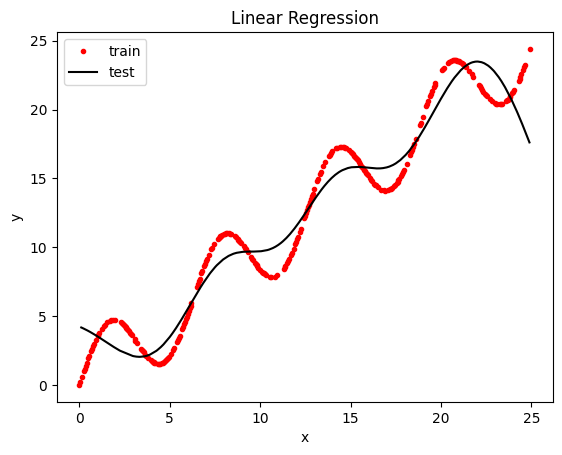

In [3]:
def evaluate(ys, ys_pred):
    std = torch.sqrt(torch.mean((ys - ys_pred).abs() ** 2))
    return std.item()

(xs, ys), (o_x, o_y) = load_data('train.txt')
ndim = xs.shape[1]

model = LinearModel(ndim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

for i in range(1000):
    model.train()
    y_preds = model(xs)
    loss = torch.mean(torch.sqrt(1e-12 + (ys - y_preds) ** 2))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 100 == 1:
        print(f'loss is {loss.item():.4f}')

# Evaluate on training set
model.eval()
with torch.no_grad():
    y_preds = model(xs)
    std = evaluate(ys, y_preds)
    print('训练集预测值与真实值的标准差：{:.1f}'.format(std))

# Evaluate on test set
(xs_test, ys_test), (o_x_test, o_y_test) = load_data('test.txt')
with torch.no_grad():
    y_test_preds = model(xs_test)
    std = evaluate(ys_test, y_test_preds)
    print('测试集预测值与真实值的标准差：{:.1f}'.format(std))

# 可视化
plt.plot(o_x, o_y, 'ro', markersize=3)
plt.plot(o_x_test, y_test_preds.numpy(), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend(['train', 'test', 'pred'])
plt.show()
